In [34]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForQuestionAnswering, AutoModelForCausalLM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# MPS 가용성 체크 및 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f'processing device is set to : {device}')

def model_select(model_name):
    models = {
        'PharmBERT': ("Lianglab/PharmBERT-uncased", AutoModel),
        'PharmBERT-cased': ("Lianglab/PharmBERT-cased", AutoModelForMaskedLM),
        'biobert_v1.1': ("dmis-lab/biobert-v1.1", AutoModel),
        'biobert_v1.2': ("dmis-lab/biobert-base-cased-v1.2", AutoModelForMaskedLM),
        'biobert-large-cased-squad': ("dmis-lab/biobert-large-cased-v1.1-squad", AutoModelForQuestionAnswering),
        'biobert-large-cased': ("dmis-lab/biobert-large-cased-v1.1", AutoModelForQuestionAnswering),
        'biobert-pubmed': ("clagator/biobert_v1.1_pubmed_nli_sts", AutoModel),
        'BioMedGPT': ("PharMolix/BioMedGPT-LM-7B", AutoModelForCausalLM),
        'BiomedBERT': ("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext", AutoModel),
        'bert-base-uncased': ("bert-base-uncased", AutoModel),
    }
    model_path, model_class = models.get(model_name, (model_name, AutoModel))
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = model_class.from_pretrained(model_path, output_hidden_states=True).to(device)
    print(f"model name: {model_path}")
    return model, tokenizer

model_name = 'biobert-pubmed'
model, tokenizer = model_select(model_name)

processing device is set to : mps
model name: clagator/biobert_v1.1_pubmed_nli_sts


In [2]:
df = pd.read_csv('./drug-SE adjacency matrix.csv', index_col=0)
drug_names = df.index.tolist()
side_effect_names = df.columns.tolist()
df

,abdominal cramps,abdominal pain,gastrointestinal pain,amblyopia,anaemia,anorexia,decreased appetite,anxiety,arrhythmia,asthenia,...,diabetic foot infection,ventilator associated pneumonia,pain neck/shoulder,corneal dystrophy,vitreous prolapse,pupillary reflex impaired,pupillary deformity,retinal scar,meniere's disease aggravated,arcus juvenilis
carnitine,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
gamma-aminobutyric,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-aminolevulinic,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leucovorin,0,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5-methyltetrahydrofolate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lymecycline,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-3 pufas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pegfilgrastim,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
colestyramine,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [35]:

# 약물 이름을 입력받아 BERT 임베딩을 생성하는 함수
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}  # 입력을 디바이스로 이동
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()

# 약물 이름 입력받기 (샘플 수 증가)
embeddings = np.array([get_bert_embedding(drug) for drug in drug_names])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


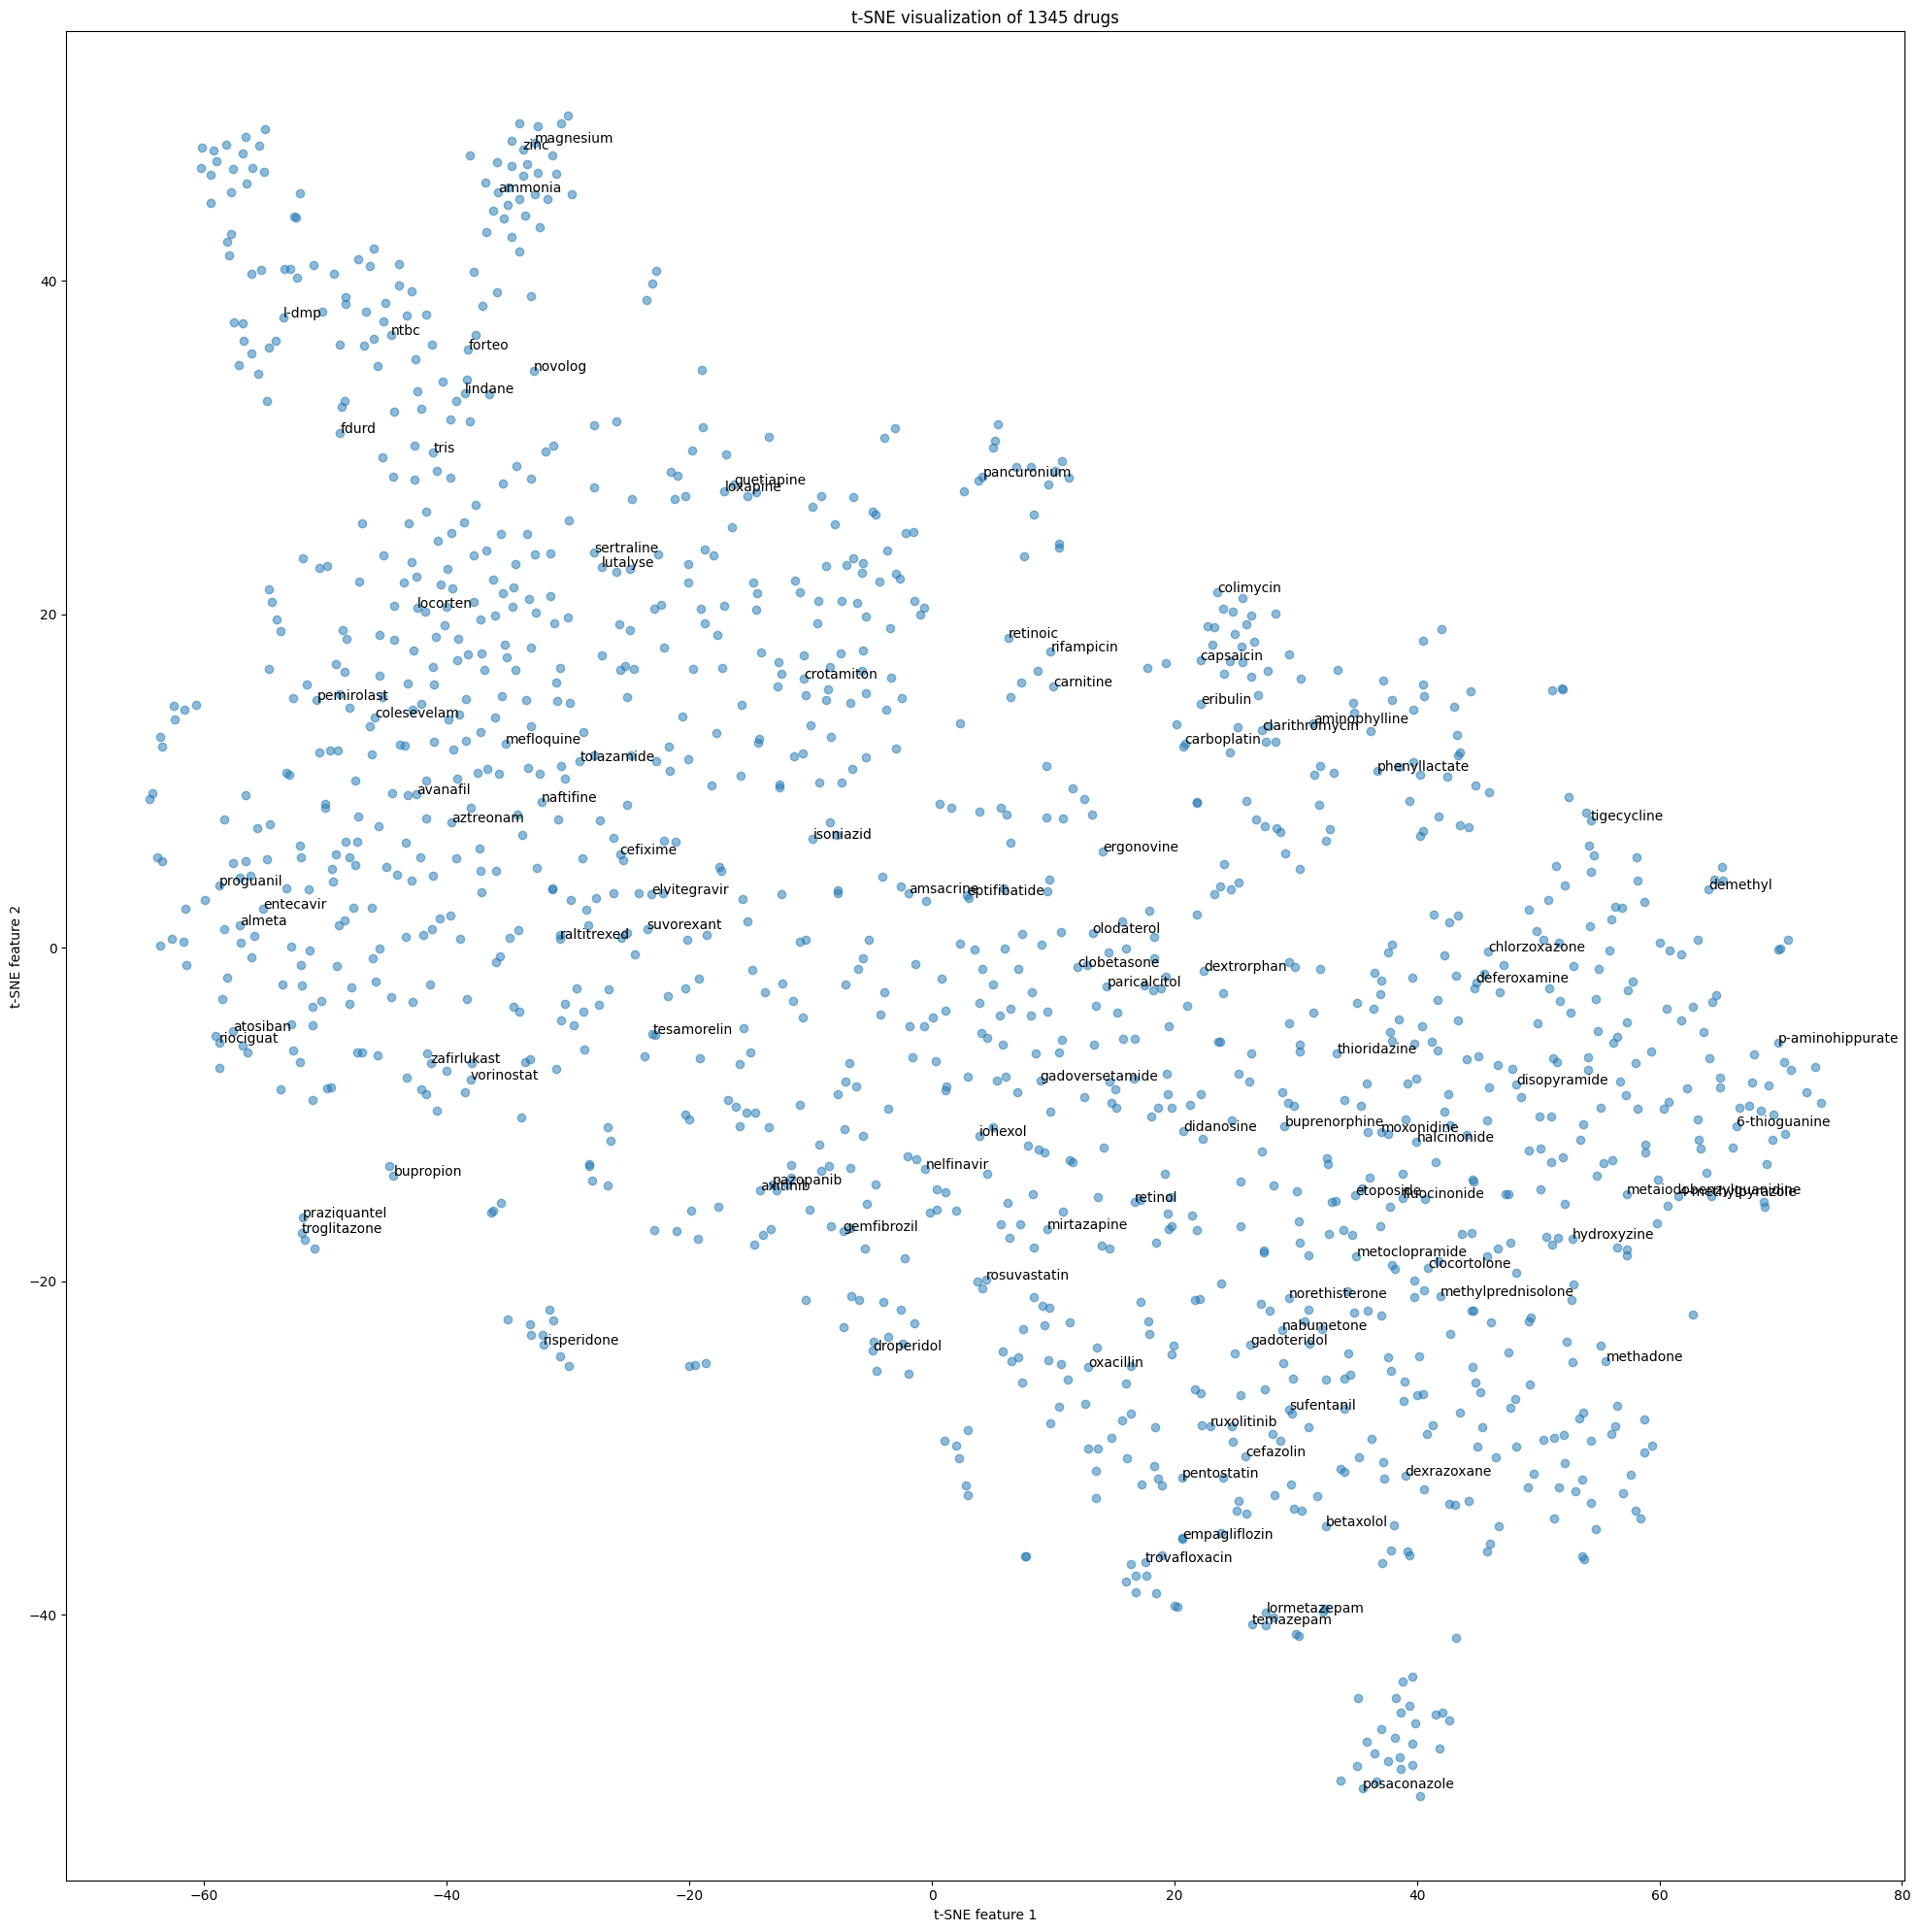

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 가정: embeddings와 drug_names가 이미 준비되어 있다고 가정합니다.

# 1. PCA를 사용한 차원 축소
pca = PCA(n_components=50)  # 50차원으로 축소
embeddings_pca = pca.fit_transform(embeddings)

# 2. t-SNE 파라미터 설정
perplexity = 30  # sqrt(1345) ≈ 36.7, 30은 좋은 시작점입니다.
n_iter = 5000    # 반복 횟수 증가
learning_rate = 200  # 학습률 증가

# 3. t-SNE 실행
tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
            learning_rate=learning_rate, random_state=42)
tsne_results = tsne.fit_transform(embeddings_pca)

# 4. 시각화
plt.figure(figsize=(20, 20))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)

# 5. 일부 약물 이름 표시 (모든 이름을 표시하면 너무 복잡해집니다)
n_labels = 100  # 표시할 약물 이름의 수
step = len(drug_names) // n_labels
for i in range(0, len(drug_names), step):
    plt.annotate(drug_names[i], (tsne_results[i, 0], tsne_results[i, 1]))

plt.title(f't-SNE visualization of {len(drug_names)} drugs')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.tight_layout()
plt.show()

# 6. 인터랙티브 시각화 (선택사항)
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    mode='markers',
    marker=dict(color=tsne_results[:, 0], size=5),
    text=drug_names,
    hoverinfo='text'
))

fig.update_layout(title=f't-SNE visualization of {len(drug_names)} drugs')
# fig.show()

/Users/nedstar/miniforge3/envs/tf-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
kanamycin, 5-azacytidine, acyclovir, bendrofluazide, enflurane, famciclovir, famotidine, felbamate, felodipine, fenofibrate, fenoldopam, fenoprofen, fentanyl, fexofenadine, finasteride, flavoxate, flecainide, fdurd, fluconazole, 5-fluorocytosine, fludarabine, famp, fludrocortisone, fluphenazine, flumazenil, flumethasone, flunisolide, flunitrazepam, fluocinolone, fluocinonide, fluorometholone, 5-fu, fluoxetine, fluoxymesterone, flurandrenolone, flurazepam, flurbiprofen, flutamide, fluticasone, fluvastatin, fluvoxamine, folate, formoterol, foscarnet, fosfomycin, fosinopril, furosemide, fusidic, ifosfamide, isoflurane, ketamine, ketoconazole, ketoprofen, ketorolac, ketotifen, oxiconazole, sevoflurane, succinylcholine, sulconazole, sulfamethoxazole, ferumoxytol, fluoride, fluorescein, 5-aza-2'-deoxycytidine, fe(iii), asp-tyr(so3h)-met-gly-trp-met-asp-phe-nh2, fosphenytoin, photofrin, remifentanil, fosinoprilat, fenofibric, sertaconazole, frovatriptan, fotemustine, ustekinumab, f

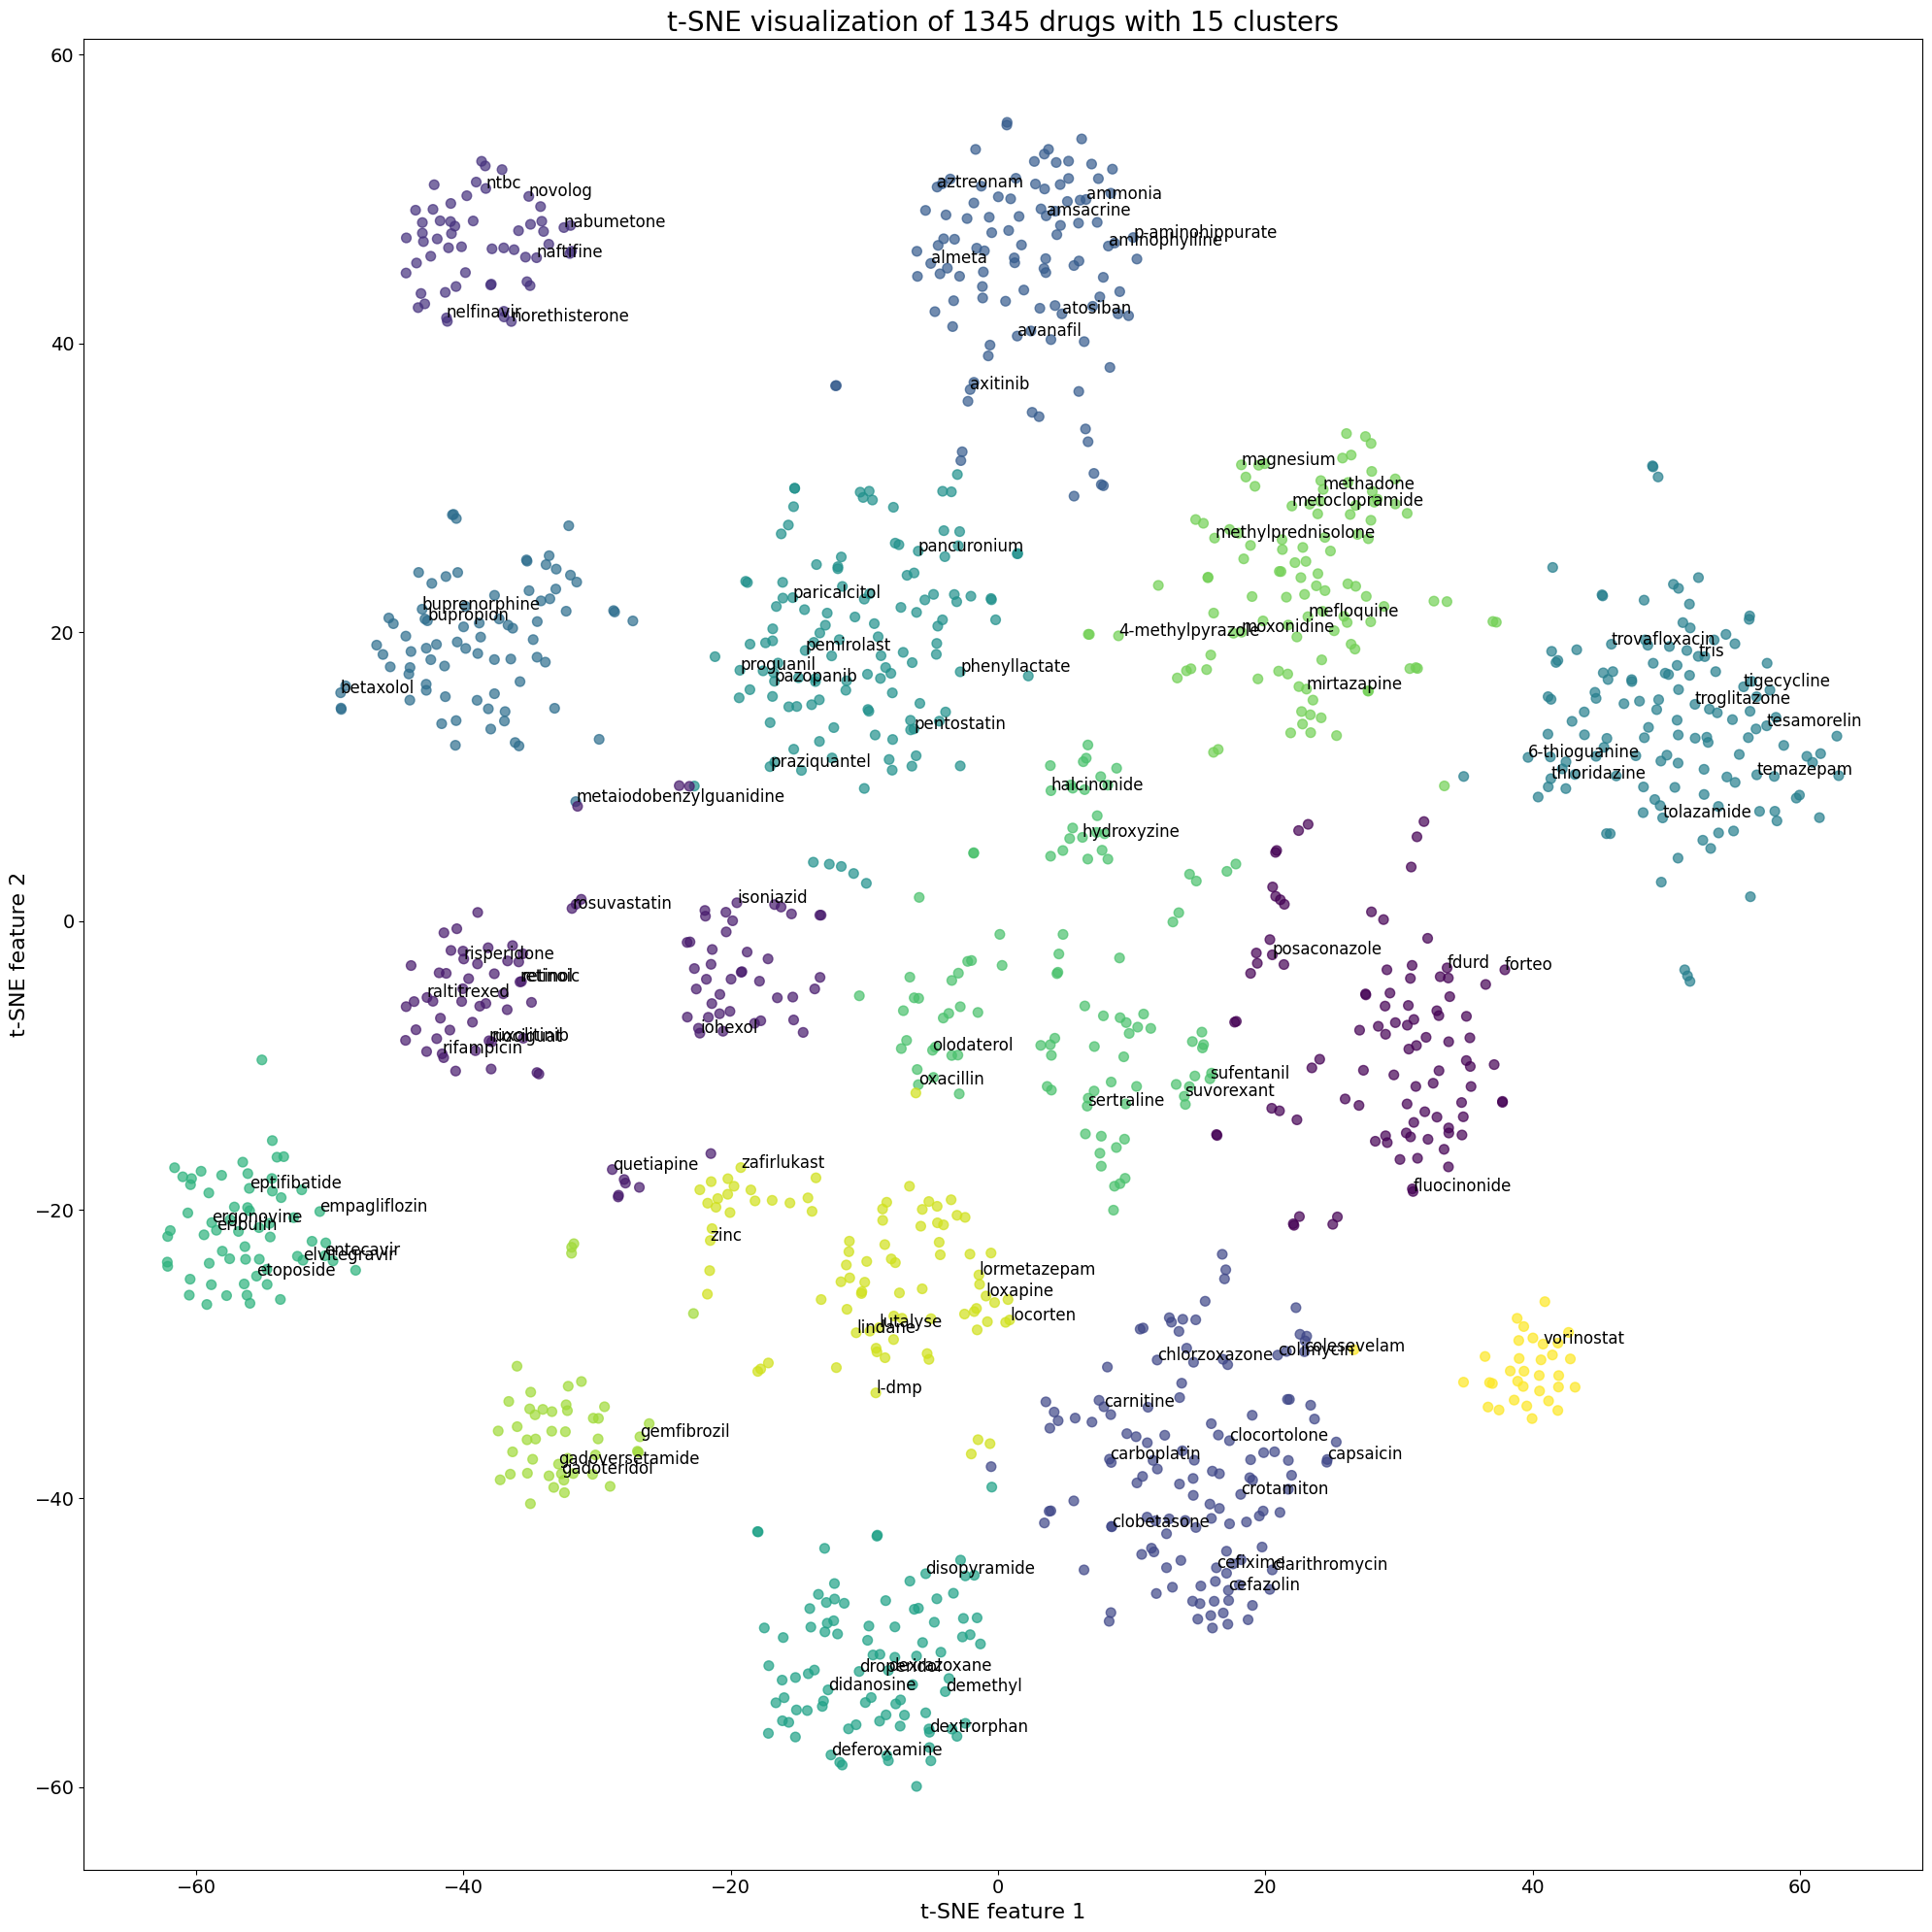

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from collections import defaultdict

# 가정: embeddings와 drug_names가 이미 준비되어 있다고 가정합니다.

# 1. PCA를 사용한 차원 축소
pca = PCA(n_components=50)  # 50차원으로 축소
embeddings_pca = pca.fit_transform(embeddings)

# 2. t-SNE 파라미터 설정
perplexity = 30
n_iter = 5000
learning_rate = 200

# 3. t-SNE 실행
tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, learning_rate=learning_rate, random_state=42)
tsne_results = tsne.fit_transform(embeddings_pca)

# 4. K-means 클러스터링
n_clusters = 15  # 클러스터 수를 설정 (필요에 따라 조정 가능)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_results)

# 5. Matplotlib을 사용한 시각화 (글씨체 크기 조정)
plt.figure(figsize=(20, 20))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=50)  # s 파라미터로 점 크기 조정
# plt.colorbar(scatter) #컬러바 표시

# 6. 각 클러스터에 속한 약물 이름 리스트 생성
cluster_drug_lists = defaultdict(list)

for drug_name, cluster_label in zip(drug_names, cluster_labels):
    cluster_drug_lists[cluster_label].append(drug_name)

# 7. 각 클러스터의 약물 리스트를 순서대로 출력하고 파일로 저장
output_filename = f"./임베딩 시각화 결과/{model_name}_drug_clusters.txt"

with open(output_filename, 'w', encoding='utf-8') as f:
    for cluster_id in range(n_clusters):
        cluster_info = f"Cluster {cluster_id}:\n"
        drug_list = cluster_drug_lists[cluster_id]
        cluster_info += ", ".join(drug_list) + "\n\n"
        
        print(cluster_info)  # 콘솔에 출력
        f.write(cluster_info)  # 파일에 저장

print(f"클러스터 정보가 '{output_filename}' 파일로 저장되었습니다.")

# 일부 약물 이름 표시 (글씨체 크기 조정)
n_labels = 100
step = len(drug_names) // n_labels
for i in range(0, len(drug_names), step):
    plt.annotate(drug_names[i], (tsne_results[i, 0], tsne_results[i, 1]), fontsize=12)  # fontsize로 글씨체 크기 조정

plt.title(f't-SNE visualization of {len(drug_names)} drugs with {n_clusters} clusters', fontsize=20)
plt.xlabel('t-SNE feature 1', fontsize=16)
plt.ylabel('t-SNE feature 2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# 시각화 결과를 파일로 저장
output_filename = f"./임베딩 시각화 결과/{model_name}_drug_clusters.png"
plt.savefig(output_filename)
plt.show()

In [7]:

# 6. Plotly를 사용한 인터랙티브 시각화 (글씨체 크기 조정)
fig = go.Figure(data=go.Scatter(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    mode='markers',
    marker=dict(
        color=cluster_labels,
        colorscale='Rainbow',
        size=5  # 마커 크기 증가
    ),
    text=drug_names,
    hoverinfo='text'
))

fig.update_layout(
    title=dict(
        text=f't-SNE visualization of {len(drug_names)} drugs with {n_clusters} clusters',
        font=dict(size=24)  # 제목 글씨체 크기
    ),
    xaxis=dict(
        title="t-SNE feature 1",
        titlefont=dict(size=18),  # x축 레이블 글씨체 크기
        tickfont=dict(size=14)  # x축 눈금 글씨체 크기
    ),
    yaxis=dict(
        title="t-SNE feature 2",
        titlefont=dict(size=18),  # y축 레이블 글씨체 크기
        tickfont=dict(size=14)  # y축 눈금 글씨체 크기
    ),
    hoverlabel=dict(font_size=14)  # 호버 텍스트 글씨체 크기
)

fig.show()

In [2]:
# BERT 모델과 토크나이저 로드 (예: 'bert-base-uncased')
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## 두 벡터 비교하기

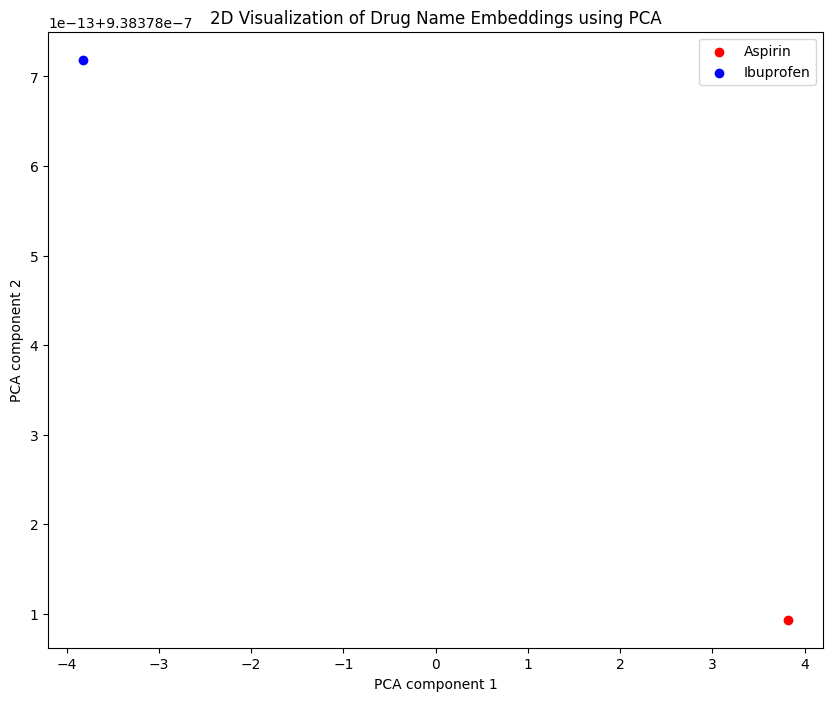

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel

# BERT 모델과 토크나이저 로드 (예: 'bert-base-uncased')
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def get_drug_embedding(drug_name):
    new_drug_name = drug_name
    new_tokens = tokenizer.tokenize(new_drug_name)
    new_tokens = ['[CLS]'] + new_tokens + ['[SEP]']
    new_input_ids = tokenizer.convert_tokens_to_ids(new_tokens)
    new_input_ids = torch.tensor([new_input_ids])
    new_input_ids = new_input_ids.to(device)
    
    with torch.no_grad():
        new_outputs = model(new_input_ids)
        new_embedding = new_outputs.hidden_states[-1].squeeze(0)
        new_embedding = new_embedding.mean(dim=0)
    
    return new_embedding

# 두 약물 이름 설정
drug1_name = "Aspirin"
drug2_name = "Ibuprofen"

# 임베딩 생성
drug1_embedding = get_drug_embedding(drug1_name)
drug2_embedding = get_drug_embedding(drug2_name)

# CPU로 이동 및 NumPy 배열로 변환
drug1_embedding = drug1_embedding.cpu().numpy()
drug2_embedding = drug2_embedding.cpu().numpy()

# 두 임베딩 결합
combined_embedding = np.vstack((drug1_embedding, drug2_embedding))

# PCA를 사용하여 2D로 차원 축소
pca = PCA(n_components=2)
embedded = pca.fit_transform(combined_embedding)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedded[0, 0], embedded[0, 1], c='r', label=drug1_name)
plt.scatter(embedded[1, 0], embedded[1, 1], c='b', label=drug2_name)
plt.legend()
plt.title('2D Visualization of Drug Name Embeddings using PCA')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()